In [2]:
import rasterio
import rasterio.mask
from rasterio.enums import Resampling
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from rasterstats import zonal_stats


In [3]:
landsat_path  = Path(r"C:/Users/gahat/OneDrive - New Mexico State University/Semester III/Advanced GIS Programming 598/Grad Project/Dataset/LC09_L2SP_033038_20240527_20240528_02_T1/")


In [4]:
# Paths
b4_path = r"C:/Users/gahat/OneDrive - New Mexico State University/Semester III/Advanced GIS Programming 598/Grad Project/Dataset/LC09_L2SP_033038_20240527_20240528_02_T1/LC09_L2SP_033038_20240527_20240528_02_T1_SR_B4.TIF"
b5_path = r"C:/Users/gahat/OneDrive - New Mexico State University/Semester III/Advanced GIS Programming 598/Grad Project/Dataset/LC09_L2SP_033038_20240527_20240528_02_T1/LC09_L2SP_033038_20240527_20240528_02_T1_SR_B5.TIF"
boundary_path=r'C:\Users\gahat\OneDrive - New Mexico State University\Semester III\Advanced GIS Programming 598\Grad Project\Dataset\City_Limits\El Paso.shp'
tracts=r'C:\Users\gahat\OneDrive - New Mexico State University\Semester III\Advanced GIS Programming 598\Grad Project\Dataset\City_Limits\El Paso County.shp'


In [5]:


# -----------------------------
# 2. Read boundary
# -----------------------------
boundary = gpd.read_file(boundary_path)

# Read CRS of raster to match boundary CRS
with rasterio.open(b4_path) as src:
    raster_crs = src.crs

# Reproject boundary if needed
if boundary.crs != raster_crs:
    boundary = boundary.to_crs(raster_crs)

geoms = [feature.__geo_interface__ for feature in boundary.geometry]

# -----------------------------
# 3. Clip B4 (Red)
# -----------------------------
with rasterio.open(b4_path) as src_red:
    red_clip, red_transform = rasterio.mask.mask(src_red, geoms, crop=True)
    red_meta = src_red.meta.copy()
    red_clip = red_clip[0].astype("float32")  # unpack single band
    
red_meta.update({
    "height": red_clip.shape[0],
    "width": red_clip.shape[1],
    "transform": red_transform
})

# -----------------------------
# 4. Clip B5 (NIR)
# -----------------------------
with rasterio.open(b5_path) as src_nir:
    nir_clip, nir_transform = rasterio.mask.mask(src_nir, geoms, crop=True)
    nir_meta = src_nir.meta.copy()
    nir_clip = nir_clip[0].astype("float32")

nir_meta.update({
    "height": nir_clip.shape[0],
    "width": nir_clip.shape[1],
    "transform": nir_transform
})

print("Clipping completed successfully!")


Clipping completed successfully!


In [6]:
# -----------------------------
# Compute NDVI from clipped bands
# -----------------------------
ndvi = (nir_clip - red_clip) / (nir_clip + red_clip)

# Avoid division by zero
ndvi[(nir_clip + red_clip) == 0] = np.nan

print("NDVI computed!")


NDVI computed!


C:\Users\gahat\AppData\Local\Temp\ipykernel_4728\492507896.py:4: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir_clip - red_clip) / (nir_clip + red_clip)


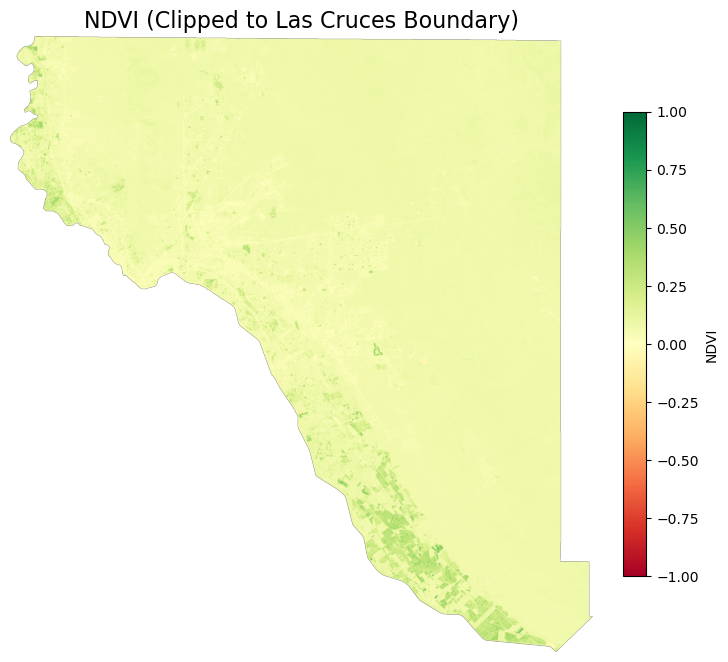

In [7]:
plt.figure(figsize=(10, 8))
plt.imshow(ndvi, cmap="RdYlGn", vmin=-1, vmax=1)
plt.title("NDVI (Clipped to Las Cruces Boundary)", fontsize=16)
plt.axis("off")
cbar = plt.colorbar(fraction=0.03, pad=0.04)
cbar.set_label("NDVI")
plt.show()


In [33]:
print("NDVI Statistics:")
print("Min:", np.nanmin(ndvi))
print("Max:", np.nanmax(ndvi))
print("Mean:", np.nanmean(ndvi))
print("Std Dev:", np.nanstd(ndvi))


NDVI Statistics:
Min: -0.18403727
Max: 0.6399855
Mean: 0.08203885
Std Dev: 0.045892946


In [36]:
import rasterio

# Replace NaNs with a numeric nodata value for saving
ndvi_to_save = ndvi.copy()
ndvi_to_save[np.isnan(ndvi_to_save)] = -9999

ndvi_out_path = r'C:\Users\gahat\OneDrive - New Mexico State University\Semester III\Advanced GIS Programming 598\Grad Project\data output\NDVI_clipped.tif'

ndvi_meta = red_meta.copy()
ndvi_meta.update({
    "dtype": "float32",
    "count": 1,
    "nodata": -9999
})

with rasterio.open(ndvi_out_path, "w", **ndvi_meta) as dst:
    dst.write(ndvi_to_save.astype("float32"), 1)

print("NDVI raster saved to:", ndvi_out_path)

NDVI raster saved to: C:\Users\gahat\OneDrive - New Mexico State University\Semester III\Advanced GIS Programming 598\Grad Project\data output\NDVI_clipped.tif


In [37]:
import geopandas as gpd
from rasterstats import zonal_stats

tracts_path = r"C:\Users\gahat\OneDrive - New Mexico State University\Semester III\Advanced GIS Programming 598\Grad Project\Dataset\City_Limits\El Paso County.shp"

# Read tracts shapefile
tracts_gdf = gpd.read_file(tracts_path)

# Match CRS to NDVI raster
with rasterio.open(ndvi_out_path) as src:
    ndvi_crs = src.crs

if tracts_gdf.crs != ndvi_crs:
    tracts_gdf = tracts_gdf.to_crs(ndvi_crs)

print("Tracts CRS:", tracts_gdf.crs)
print("NDVI CRS:", ndvi_crs)


Tracts CRS: PROJCS["WGS 84 / UTM zone 13N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
NDVI CRS: PROJCS["WGS 84 / UTM zone 13N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NO

In [38]:
stats_ndvi = zonal_stats(
    tracts_gdf,
    ndvi_out_path,                 # <--- this is the key change
    stats=["mean", "median", "min", "max", "std"],
    nodata=-9999
)

print("Number of zones (tracts):", len(stats_ndvi))


Number of zones (tracts): 188


In [70]:
tracts_gdf["NDVI_mean"] = [s["mean"] for s in stats_ndvi]
tracts_gdf["NDVI_median"] = [s["median"] for s in stats_ndvi]
tracts_gdf["NDVI_min"] = [s["min"] for s in stats_ndvi]
tracts_gdf["NDVI_max"] = [s["max"] for s in stats_ndvi]
tracts_gdf["NDVI_std"] = [s["std"] for s in stats_ndvi]

# Quick check
print(tracts_gdf[["NDVI_mean", "NDVI_min", "NDVI_max"]].head())


   NDVI_mean  NDVI_min  NDVI_max
0   0.076486 -0.061127  0.221872
1   0.061232 -0.001405  0.301866
2   0.039702 -0.010448  0.286341
3   0.140192 -0.098284  0.552879
4   0.072705 -0.003393  0.191540


In [71]:
out_tracts_path = r"C:\Users\gahat\OneDrive - New Mexico State University\Semester III\Advanced GIS Programming 598\Grad Project\data output\ElPaso_tracts_NDVI.gpkg"

tracts_gdf.to_file(out_tracts_path, driver="GPKG")
print("Saved tracts with NDVI stats to:", out_tracts_path)


Saved tracts with NDVI stats to: C:\Users\gahat\OneDrive - New Mexico State University\Semester III\Advanced GIS Programming 598\Grad Project\data output\ElPaso_tracts_NDVI.gpkg


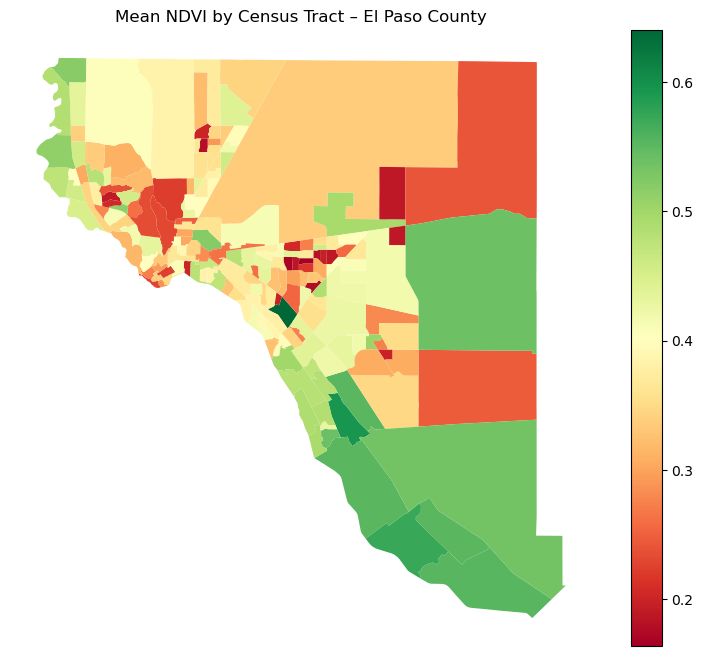

In [41]:
import matplotlib.pyplot as plt

tracts_gdf.plot(column="NDVI_max", cmap="RdYlGn", legend=True, figsize=(10, 8))
plt.title("Mean NDVI by Census Tract – El Paso County")
plt.axis("off")
plt.show()


In [42]:
# -----------------------------
# LST STEP 1: Path to ST_B10
# -----------------------------
st_path = r"C:/Users/gahat/OneDrive - New Mexico State University/Semester III/Advanced GIS Programming 598/Grad Project/Dataset/LC09_L2SP_033038_20240527_20240528_02_T1/LC09_L2SP_033038_20240527_20240528_02_T1_ST_B10.TIF"

# -----------------------------
# LST STEP 2: Clip ST_B10 to El Paso boundary
# -----------------------------
with rasterio.open(st_path) as src_st:
    st_clip, st_transform = rasterio.mask.mask(src_st, geoms, crop=True)
    st_meta = src_st.meta.copy()
    st_clip = st_clip[0].astype("float32")   # unpack single band
    st_nodata = src_st.nodata

st_meta.update({
    "height": st_clip.shape[0],
    "width": st_clip.shape[1],
    "transform": st_transform
})

print("ST_B10 clipped successfully!")


ST_B10 clipped successfully!


In [43]:
# -----------------------------
# LST STEP 3: Convert DN to LST (Kelvin and Celsius)
# Landsat C2 L2 ST_B10: LST_K = DN * 0.00341802 + 149.0
# -----------------------------
scale_factor = 0.00341802
offset = 149.0

# NoData mask
if st_nodata is not None:
    st_mask = (st_clip == st_nodata)
else:
    # For Landsat C2 ST products, nodata is usually 0
    st_mask = (st_clip == 0)

# Compute LST in Kelvin
LST_K = st_clip * scale_factor + offset
LST_K[st_mask] = np.nan

# Convert to Celsius
LST_C = LST_K - 273.15

print("LST computed (Kelvin and Celsius)!")


LST computed (Kelvin and Celsius)!


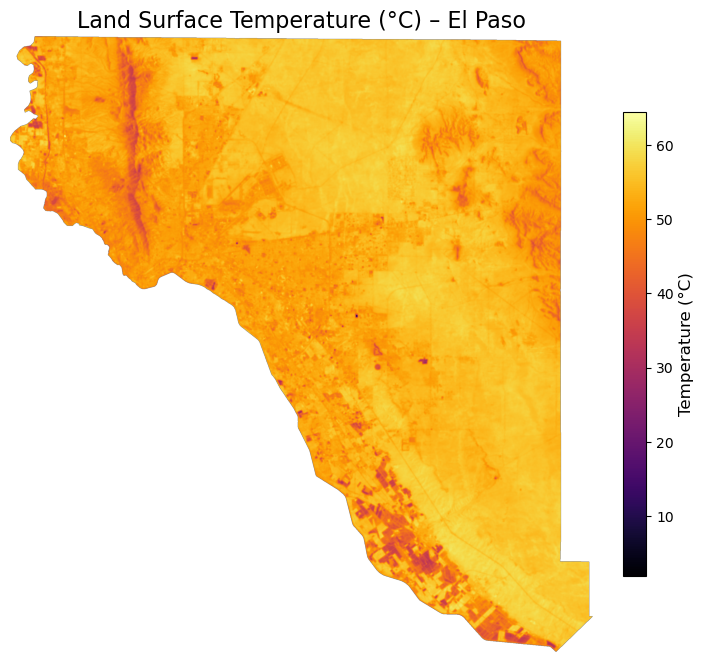

LST Statistics (°C):
Min: 1.8382263
Max: 64.52811
Mean: 53.18714
Std Dev: 3.702636


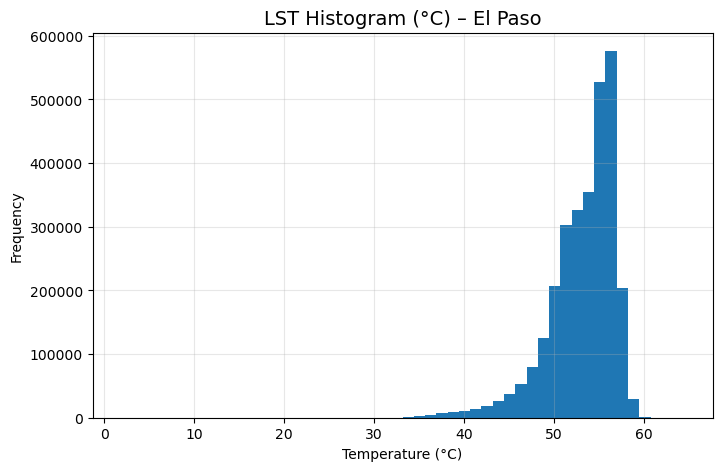

In [44]:
# -----------------------------
# LST STEP 4: Map visualization (°C)
# -----------------------------
plt.figure(figsize=(10, 8))
lst_img = plt.imshow(LST_C, cmap="inferno")
plt.title("Land Surface Temperature (°C) – El Paso", fontsize=16)
plt.axis("off")
cbar = plt.colorbar(lst_img, fraction=0.03, pad=0.04)
cbar.set_label("Temperature (°C)", fontsize=12)
plt.show()

# -----------------------------
# LST STEP 5: Stats + histogram
# -----------------------------
print("LST Statistics (°C):")
print("Min:", np.nanmin(LST_C))
print("Max:", np.nanmax(LST_C))
print("Mean:", np.nanmean(LST_C))
print("Std Dev:", np.nanstd(LST_C))

plt.figure(figsize=(8, 5))
plt.hist(LST_C[~np.isnan(LST_C)], bins=50)
plt.title("LST Histogram (°C) – El Paso", fontsize=14)
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()


In [45]:
# -----------------------------
# LST STEP 6: Save LST (°C) raster
# -----------------------------
LST_out_path = r"C:\Users\gahat\OneDrive - New Mexico State University\Semester III\Advanced GIS Programming 598\Grad Project\data output\LST_ElPaso_clipped_C.tif"

# Replace NaNs with a nodata value for saving
LST_to_save = LST_C.copy()
LST_to_save[np.isnan(LST_to_save)] = -9999

lst_meta = st_meta.copy()
lst_meta.update({
    "dtype": "float32",
    "count": 1,
    "nodata": -9999
})

with rasterio.open(LST_out_path, "w", **lst_meta) as dst:
    dst.write(LST_to_save.astype("float32"), 1)

print("LST raster (°C) saved to:", LST_out_path)


LST raster (°C) saved to: C:\Users\gahat\OneDrive - New Mexico State University\Semester III\Advanced GIS Programming 598\Grad Project\data output\LST_ElPaso_clipped_C.tif


In [60]:
# Paths
lst_path    = r"C:\Users\gahat\OneDrive - New Mexico State University\Semester III\Advanced GIS Programming 598\Grad Project\data output\LST_ElPaso_clipped_C.tif"

In [61]:
# Read tracts
tracts_gdf = gpd.read_file(tracts_path)

# Read LST CRS
with rasterio.open(lst_path) as src:
    lst_crs = src.crs

print("Tracts CRS:", tracts_gdf.crs)
print("LST CRS:", lst_crs)

# Reproject tracts if needed
if tracts_gdf.crs != lst_crs:
    tracts_gdf = tracts_gdf.to_crs(lst_crs)
    print("Reprojected tracts to LST CRS.")


Tracts CRS: EPSG:4269
LST CRS: PROJCS["WGS 84 / UTM zone 13N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Reprojected tracts to LST CRS.


In [73]:
stats_lst = zonal_stats(
    tracts_gdf,
    lst_path,
    stats=["mean", "min", "max", "std"],
    nodata=-9999  # same nodata you used when saving LST
)

# Attach to GeoDataFrame
tracts_gdf["LST_mean"] = [s["mean"] for s in stats_lst]
tracts_gdf["LST_min"]  = [s["min"]  for s in stats_lst]
tracts_gdf["LST_max"]  = [s["max"]  for s in stats_lst]
tracts_gdf["LST_std"]  = [s["std"]  for s in stats_lst]

# Quick check
tracts_gdf[["LST_mean", "LST_min", "LST_max"]].head()


,LST_mean,LST_min,LST_max
0,49.590024,32.798645,55.596832
1,50.914168,47.485870,53.265747
2,50.900365,47.338898,53.262329
3,52.461734,30.970001,61.113525
4,50.860573,48.569397,53.337524


In [74]:
import geopandas as gpd

ndvi_gpkg_path = r"C:\Users\gahat\OneDrive - New Mexico State University\Semester III\Advanced GIS Programming 598\Grad Project\data output\ElPaso_tracts_NDVI.gpkg"

tracts_ndvi = gpd.read_file(ndvi_gpkg_path)
print(tracts_ndvi.head())


  STATEFP COUNTYFP TRACTCE        GEOID    NAME             NAMELSAD  MTFCC  \
0      48      141  000401  48141000401    4.01    Census Tract 4.01  G5020   
1      48      141  001002  48141001002   10.02   Census Tract 10.02  G5020   
2      48      141  001900  48141001900      19      Census Tract 19  G5020   
3      48      141  010504  48141010504  105.04  Census Tract 105.04  G5020   
4      48      141  001112  48141001112   11.12   Census Tract 11.12  G5020   

  FUNCSTAT     ALAND  AWATER  ...   LST_mean    LST_min    LST_max   LST_std  \
0        S  16373007    3207  ...  49.590024  32.798645  55.596832  3.233112   
1        S   1263562       0  ...  50.914168  47.485870  53.265747  0.783820   
2        S    609273       0  ...  50.900365  47.338898  53.262329  1.215627   
3        S  70472454  318230  ...  52.461734  30.970001  61.113525  6.074293   
4        S   1964538       0  ...  50.860573  48.569397  53.337524  0.927903   

   NDVI_mean  NDVI_median  NDVI_min  NDVI_ma

In [75]:
tracts_gdf[["NDVI_mean", "LST_mean"]].describe()


,NDVI_mean,LST_mean
count,188.000000,188.000000
mean,0.073958,51.354987
std,0.022646,1.683920
min,0.037045,43.784113
25%,0.062205,50.805843
50%,0.068991,51.364834
75%,0.077856,51.899480
max,0.182356,56.322930


In [76]:
tracts_gdf.columns


Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry',
       'LST_mean', 'LST_min', 'LST_max', 'LST_std', 'NDVI_mean', 'NDVI_median',
       'NDVI_min', 'NDVI_max', 'NDVI_std'],
      dtype='object')

In [77]:
out_tracts_all = r"C:\Users\gahat\OneDrive - New Mexico State University\Semester III\Advanced GIS Programming 598\Grad Project\data output\ElPaso_tracts_NDVI_LST.gpkg"

tracts_gdf.to_file(out_tracts_all, driver="GPKG")
print("Saved:", out_tracts_all)


Saved: C:\Users\gahat\OneDrive - New Mexico State University\Semester III\Advanced GIS Programming 598\Grad Project\data output\ElPaso_tracts_NDVI_LST.gpkg


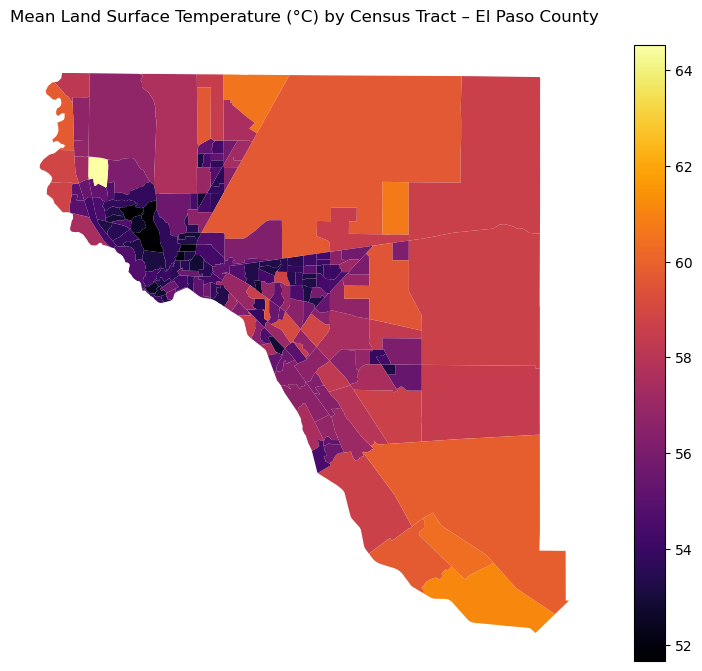

In [79]:
tracts_gdf.plot(column="LST_max", cmap="inferno", legend=True, figsize=(10, 8))
plt.title("Mean Land Surface Temperature (°C) by Census Tract – El Paso County")
plt.axis("off")
plt.show()


In [ ]:
# Spatial Autocorrelation

In [83]:
pip install pysal

Note: you may need to restart the kernel to use updated packages.Collecting pysal
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 15.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/16.4 MB ? eta -:--:--
   ----------------------- ---------------- 9.7/16.4 MB 60.2 MB/s eta 0:00:01
   ---------------------------------------- 16.4/16.4 MB 44.2 MB/s eta 0:00:00
  Created wheel for spint: filename=spint-1.0.7-py3-none-any.whl size=31364 sha256=1566bcc6002a3bc7da7bb23332776533d67e76dcdb00a57564727de754ed9113
  Stored in directory: c:\users\gahat\appdata\local\pip\cache\wheels\34\95\4d\89242282d1aebdc0ca0e417988979fd5ff7f1dbc0bee423815
Successfully built spint

   ----------------------------------------  0/18 [pulp]
   ----------------------------------------  0/18 [pulp]
   -----------------------

  DEPRECATION: Building 'spint' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'spint'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [81]:
pip install esda

   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 2.8/2.8 MB 26.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 50.2 MB/s eta 0:00:00

  Attempting uninstall: shapely

    Found existing installation: shapely 2.0.6

    Uninstalling shapely-2.0.6:

   ---------------------------------------- 0/3 [shapely]
      Successfully uninstalled shapely-2.0.6
   ---------------------------------------- 0/3 [shapely]
   ---------------------------------------- 0/3 [shapely]
   ---------------------------------------- 0/3 [shapely]
   ---------------------------------------- 0/3 [shapely]
   ---------------------------------------- 0/3 [shapely]
   ---------------------------------------- 0/3 [shapely]
   ---------------------------------------- 0/3 [shapely]
   ---------------------------------------- 0/3 [shapely]
   ------------- ---------

In [82]:
pip install libpysal

Note: you may need to restart the kernel to use updated packages.


In [86]:
from libpysal.weights import Queen, Rook
import numpy as np

gdf =tracts_gdf
# Using queen contiguity (more common)
w = Queen.from_dataframe(gdf)
w.transform = 'R'   # row-standardize


C:\Users\gahat\AppData\Local\Temp\ipykernel_26432\1969742796.py:6: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf)


In [ ]:
# 4. GLOBAL MORAN’S I (for NDVI & LST)

In [87]:
from esda.moran import Moran

y = gdf["NDVI_mean"].values
moran_ndvi = Moran(y, w)

print("Global Moran's I (NDVI):", moran_ndvi.I)
print("p-value:", moran_ndvi.p_sim)


Global Moran's I (NDVI): 0.45582766616702813
p-value: 0.001


In [88]:
y = gdf["LST_mean"].values
moran_lst = Moran(y, w)

print("Global Moran's I (LST):", moran_lst.I)
print("p-value:", moran_lst.p_sim)


Global Moran's I (LST): 0.5066592915765127
p-value: 0.001


In [ ]:
#5. LOCAL MORAN’S I (LISA) — hotspot detection

In [89]:
from esda.moran import Moran_Local

y = gdf["NDVI_mean"].values
lisa_ndvi = Moran_Local(y, w)


In [90]:
y = gdf["LST_mean"].values
lisa_lst = Moran_Local(y, w)


In [91]:
gdf["NDVI_local_I"] = lisa_ndvi.Is
gdf["NDVI_p"] = lisa_ndvi.p_sim
gdf["NDVI_q"] = lisa_ndvi.q      # cluster type


In [92]:
gdf["LST_local_I"] = lisa_lst.Is
gdf["LST_p"] = lisa_lst.p_sim
gdf["LST_q"] = lisa_lst.q


<Figure size 1000x800 with 0 Axes>

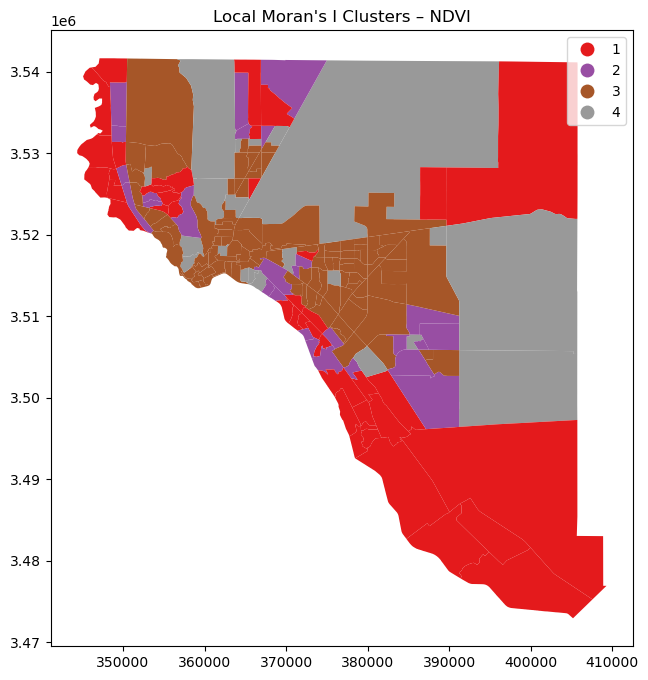

In [93]:
import matplotlib.pyplot as plt

sig = 0.05
gdf["sig_ndvi"] = (gdf["NDVI_p"] < sig)

plt.figure(figsize=(10, 8))
gdf.plot(column="NDVI_q", categorical=True, legend=True,
         figsize=(10, 8), cmap="Set1")
plt.title("Local Moran's I Clusters – NDVI")
plt.show()


In [94]:
gdf["LST_local_I"] = lisa_lst.Is
gdf["LST_p"] = lisa_lst.p_sim
gdf["LST_q"] = lisa_lst.q


<Figure size 1000x800 with 0 Axes>

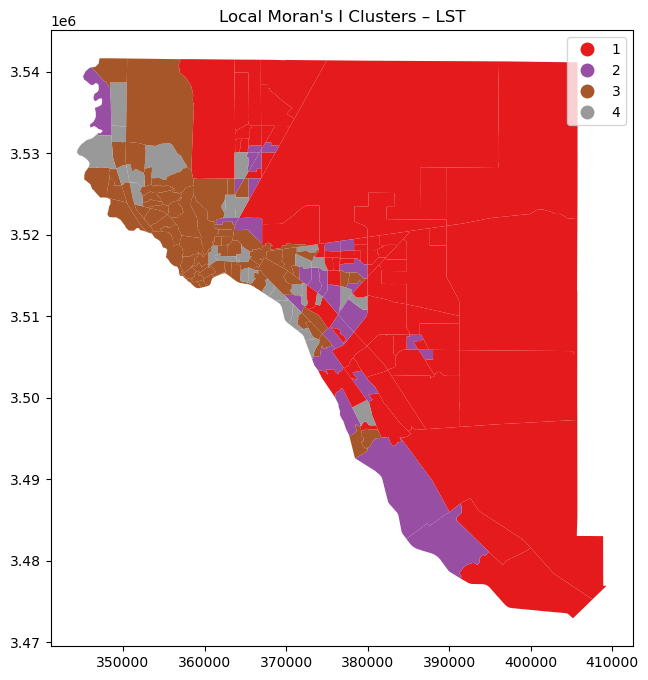

In [96]:
plt.figure(figsize=(10, 8))
gdf.plot(column="LST_q", categorical=True, legend=True,
         figsize=(10, 8), cmap="Set1")
plt.title("Local Moran's I Clusters – LST")
plt.show()


In [99]:
#OLS Regression in Python

In [101]:
pip install spreg

In [102]:
pip install mgwr

Note: you may need to restart the kernel to use updated packages.


In [103]:
from spreg import OLS
import numpy as np

y = gdf["LST_mean"].values.reshape((-1, 1))
X = gdf["NDVI_mean"].values.reshape((-1, 1))

ols_model = OLS(y, X, name_y="LST", name_x=["NDVI"])
print(ols_model.summary)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :         LST                Number of Observations:         188
Mean dependent var  :     51.3550                Number of Variables   :           2
S.D. dependent var  :      1.6839                Degrees of Freedom    :         186
R-squared           :      0.0519
Adjusted R-squared  :      0.0468
Sum squared residual:     502.744                F-statistic           :     10.1782
Sigma-square        :       2.703                Prob(F-statistic)     :    0.001668
S.E. of regression  :       1.644                Log likelihood        :    -359.222
Sigma-square ML     :       2.674                Akaike info criterion :     722.445
S.E of regression ML:      1.6353                Schwarz criterion     :     728.918

------------------------------------------------------------

In [104]:
from esda.moran import Moran

residuals = ols_model.u   # OLS residuals
moran_resid = Moran(residuals, w)

print("Residual Moran's I:", moran_resid.I)
print("p-value:", moran_resid.p_sim)


Residual Moran's I: 0.5740493544892371
p-value: 0.001


In [107]:
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW


In [108]:
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
import numpy as np

# Coordinates (centroids of census tracts)
coords = np.column_stack([gdf.geometry.centroid.x, gdf.geometry.centroid.y])

# Response variable
y = gdf["LST_mean"].values.reshape((-1, 1))

# Explanatory variable
X = gdf["NDVI_mean"].values.reshape((-1, 1))

# Select optimal bandwidth
bw = Sel_BW(coords, y, X).search()
print("Optimal bandwidth:", bw)

# Fit GWR model
gwr_model = GWR(coords, y, X, bw=bw).fit()

print(gwr_model.summary)


Optimal bandwidth: 45.0
<bound method GWRResults.summary of <mgwr.gwr.GWRResults object at 0x000002D3D3B1ED50>>


In [109]:
gdf["Intercept_GWR"] = gwr_model.params[:, 0]
gdf["NDVI_coeff_GWR"] = gwr_model.params[:, 1]
gdf["GWR_local_R2"] = gwr_model.localR2


In [112]:
print(gwr_model.summary)


<bound method GWRResults.summary of <mgwr.gwr.GWRResults object at 0x000002D3D3B1ED50>>


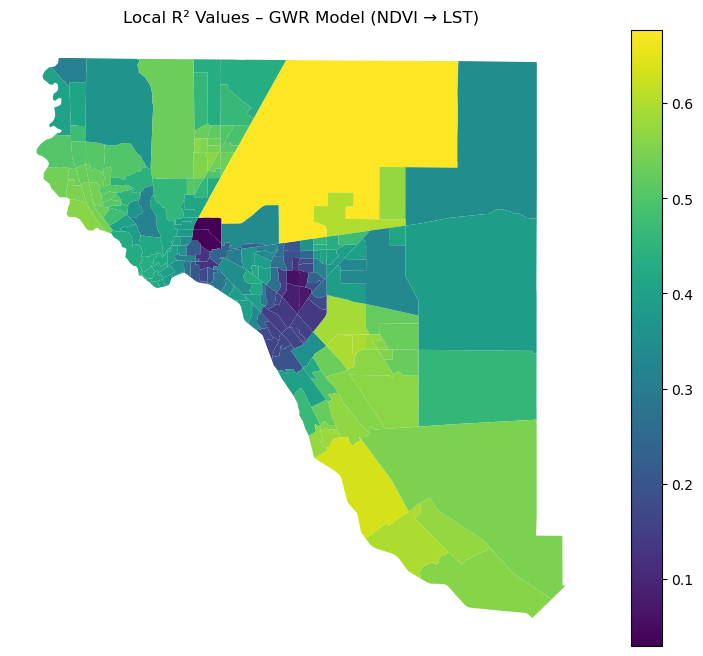

In [115]:
gdf["GWR_local_R2"] = gwr_model.localR2

gdf.plot(column="GWR_local_R2", cmap="viridis", legend=True, figsize=(10, 8))
plt.title("Local R² Values – GWR Model (NDVI → LST)")
plt.axis("off")
plt.show()


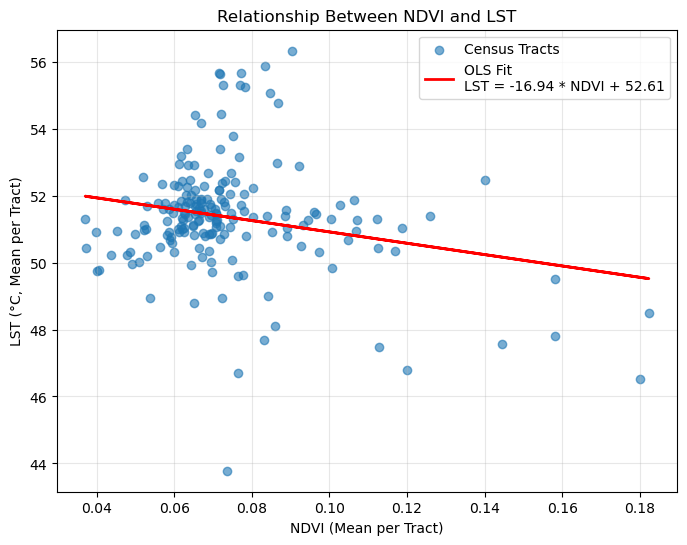

In [116]:
import numpy as np
import matplotlib.pyplot as plt

x = gdf["NDVI_mean"]
y = gdf["LST_mean"]

# Fit OLS line using numpy
slope, intercept = np.polyfit(x, y, 1)
line = slope * x + intercept

plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.6, label="Census Tracts")
plt.plot(x, line, color="red", linewidth=2, label=f"OLS Fit\nLST = {slope:.2f} * NDVI + {intercept:.2f}")

plt.xlabel("NDVI (Mean per Tract)")
plt.ylabel("LST (°C, Mean per Tract)")
plt.title("Relationship Between NDVI and LST")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


In [117]:
# Compute R²
y_pred = slope * x + intercept
SS_res = np.sum((y - y_pred)**2)
SS_tot = np.sum((y - np.mean(y))**2)
R2 = 1 - SS_res / SS_tot

print("R²:", R2)


R²: 0.051882655991301374


In [118]:
import geopandas as gpd

# Load tracts and parks
tracts = gdf   # your merged NDVI + LST + geometry
parks = gpd.read_file(r"C:\Users\gahat\OneDrive - New Mexico State University\Semester III\Advanced GIS Programming 598\Grad Project\Dataset\Parks\Parks.shp")

# Make sure CRS matches
parks = parks.to_crs(tracts.crs)

# Identity overlay to calculate park area inside each tract
park_within_tract = gpd.overlay(parks, tracts, how='intersection')


In [119]:
park_within_tract["park_area"] = park_within_tract.geometry.area


In [122]:
park_area_by_tract = park_within_tract.groupby("GEOID")["park_area"].sum().reset_index()


In [123]:
tracts = tracts.merge(park_area_by_tract, on="GEOID", how="left")
tracts["park_area"] = tracts["park_area"].fillna(0)
tracts["tract_area"] = tracts.geometry.area
tracts["park_percent"] = tracts["park_area"] / tracts["tract_area"] * 100


In [126]:
tracts.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry',
       'LST_mean', 'LST_min', 'LST_max', 'LST_std', 'NDVI_mean', 'NDVI_median',
       'NDVI_min', 'NDVI_max', 'NDVI_std', 'NDVI_local_I', 'NDVI_p', 'NDVI_q',
       'LST_local_I', 'LST_p', 'LST_q', 'sig_ndvi', 'Intercept_GWR',
       'NDVI_coeff_GWR', 'GWR_local_R2', 'park_area', 'tract_area',
       'park_percent'],
      dtype='object')

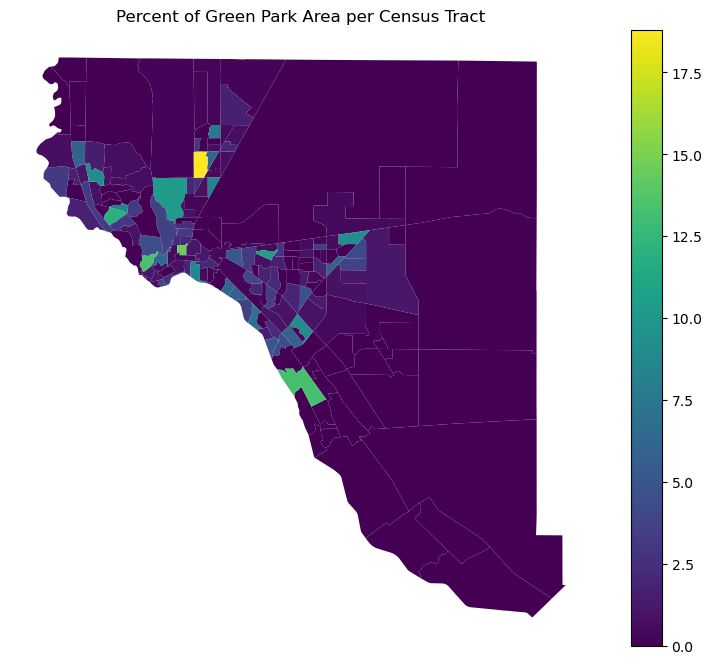

In [128]:
tracts.plot(column="park_percent", cmap="viridis", legend=True, figsize=(10, 8))
plt.title("Percent of Green Park Area per Census Tract")
plt.axis("off")
plt.show()


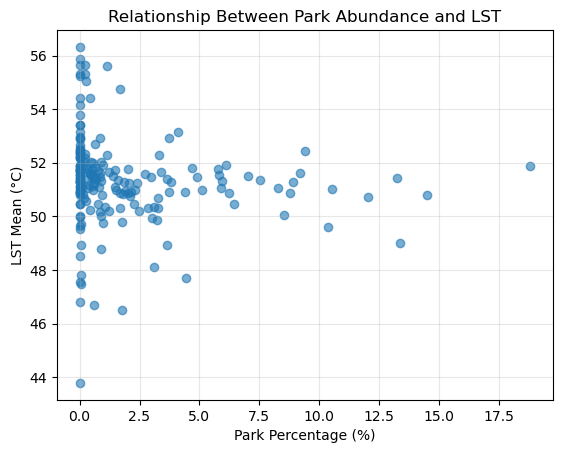

In [129]:
plt.scatter(tracts["park_percent"], tracts["LST_mean"], alpha=0.6)
plt.xlabel("Park Percentage (%)")
plt.ylabel("LST Mean (°C)")
plt.title("Relationship Between Park Abundance and LST")
plt.grid(alpha=0.3)
plt.show()


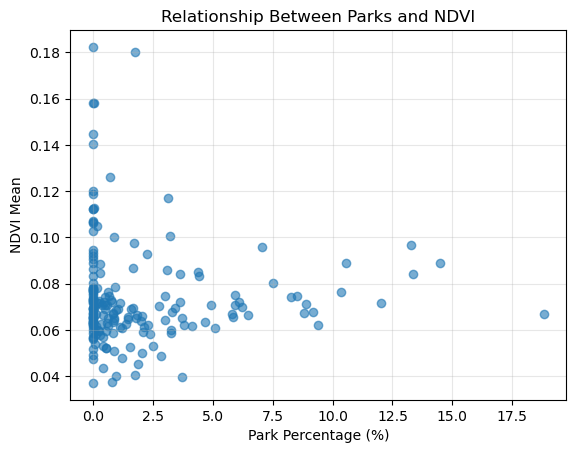

In [130]:
plt.scatter(tracts["park_percent"], tracts["NDVI_mean"], alpha=0.6)
plt.xlabel("Park Percentage (%)")
plt.ylabel("NDVI Mean")
plt.title("Relationship Between Parks and NDVI")
plt.grid(alpha=0.3)
plt.show()


In [131]:
tracts_sorted = tracts.sort_values("park_percent", ascending=False)
tracts_sorted[["GEOID", "park_percent", "NDVI_mean", "LST_mean"]].head()


,GEOID,park_percent,NDVI_mean,LST_mean
120,48141000114,18.809783,0.067024,51.889879
20,48141002400,14.490324,0.089020,50.806373
63,48141001502,13.373035,0.084051,49.009658
160,48141010401,13.252520,0.096593,51.435741
97,48141001117,12.020475,0.071765,50.711772


In [134]:
#Kernel Density Estimation (KDE)

In [132]:
import geopandas as gpd

parks = gpd.read_file(r"C:\Users\gahat\OneDrive - New Mexico State University\Semester III\Advanced GIS Programming 598\Grad Project\Dataset\Parks\Parks.shp")
tracts = gdf  # your merged NDVI + LST + geometry data

# Match CRS
parks = parks.to_crs(tracts.crs)

# Convert polygon to point (centroid)
park_points = parks.copy()
park_points["geometry"] = parks.centroid


In [133]:
import numpy as np

coords = np.vstack([park_points.geometry.x, park_points.geometry.y]).T


In [135]:
from scipy.stats import gaussian_kde

# Fit KDE model
kde = gaussian_kde(coords.T, bw_method=0.2)  # adjust bandwidth later


In [136]:
import numpy as np

# Bounding box of tracts (area to evaluate KDE)
minx, miny, maxx, maxy = tracts.total_bounds

# Create grid resolution (adjust as needed)
xgrid = np.linspace(minx, maxx, 300)
ygrid = np.linspace(miny, maxy, 300)
xx, yy = np.meshgrid(xgrid, ygrid)

grid_coords = np.vstack([xx.ravel(), yy.ravel()])


In [137]:
density = kde(grid_coords).reshape(xx.shape)


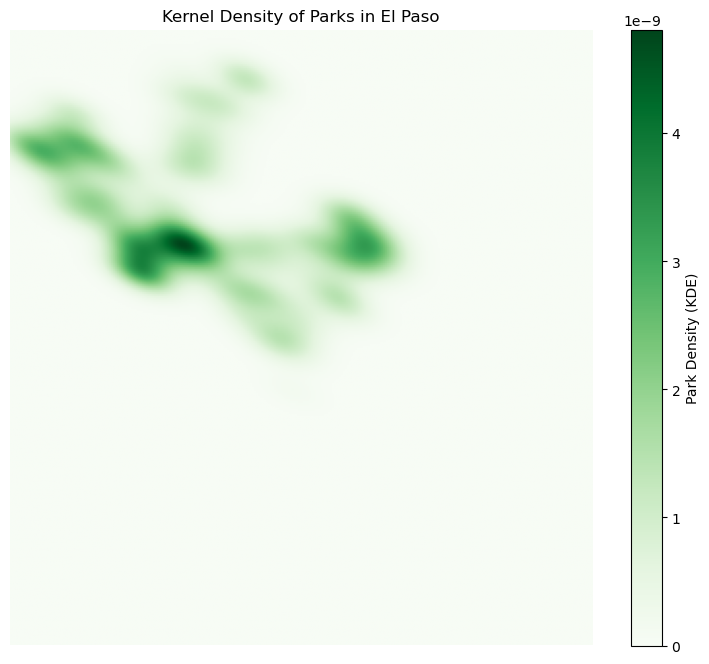

In [140]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(density, extent=[minx, maxx, miny, maxy],
           origin='lower', cmap="Greens")
plt.colorbar(label="Park Density (KDE)")
plt.title("Kernel Density of Parks in El Paso")
plt.axis("off")
plt.show()


In [141]:
import rasterio
from rasterio.transform import from_origin

resolution_x = (maxx - minx) / 300
resolution_y = (maxy - miny) / 300
transform = from_origin(minx, maxy, resolution_x, resolution_y)

out_path = "park_kde.tif"

with rasterio.open(
    out_path,
    "w",
    driver="GTiff",
    height=density.shape[0],
    width=density.shape[1],
    count=1,
    dtype="float32",
    crs=tracts.crs,
    transform=transform
) as dst:
    dst.write(density.astype("float32"), 1)

print("Saved KDE raster:", out_path)


Saved KDE raster: park_kde.tif


In [142]:
from rasterstats import zonal_stats

kde_stats = zonal_stats(
    tracts,
    out_path,
    stats=["mean", "max"],
    nodata=None
)

tracts["park_kde_mean"] = [s["mean"] for s in kde_stats]
tracts["park_kde_max"] = [s["max"] for s in kde_stats]


C:\Users\gahat\anaconda3\Lib\site-packages\rasterstats\io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


In [144]:
tracts["park_kde_mean"]

0      6.381428e-44
1      2.246138e-31
2      1.096949e-25
3      3.185563e-33
4      0.000000e+00
           ...     
183    3.441340e-16
184    6.879497e-20
185    3.664659e-11
186    5.610026e-43
187    7.159414e-12
Name: park_kde_mean, Length: 188, dtype: float64